In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import os
import base64
import json
import warnings
import folium
from matplotlib.gridspec import GridSpec
from sqlalchemy import create_engine
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import fcluster
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.base import clone
from scipy.spatial.distance import euclidean, cityblock
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from shapely import wkt
from shapely.geometry import Point
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
engine = create_engine('sqlite:///pba.db')
with engine.connect() as conn:
    df_player = pd.read_sql('SELECT * FROM player', con=conn)
    df_avg_stat = pd.read_sql('SELECT * FROM avg_stat', con=conn)
    df_tot_stat = pd.read_sql('SELECT * FROM total_stat', con=conn)
    df_team = pd.read_sql('SELECT * FROM team', con=conn)
    df_team_avg_stat = pd.read_sql('SELECT * FROM team_avg_stat', con=conn)
    df_team_tot_stat = pd.read_sql('SELECT * FROM team_total_stat', con=conn)
    df_history = pd.read_sql('SELECT * FROM history', con=conn)
    df_conference = pd.read_sql('SELECT * FROM conference', con=conn)
    
engine.dispose()

In [3]:
def get_total_stat():
    """Return all total stat"""
    df_all_total = (pd.merge(df_tot_stat.add_prefix('ply_'),
                        df_team_tot_stat.add_prefix('tm_'), how='left',
                        left_on=['ply_team_id', 'ply_hist_id'],
                         right_on=['tm_team_id', 'tm_hist_id']))
    return df_all_total

def get_average_stat():
    """Return all average stat"""
    df_all_average = (pd.merge(df_avg_stat.add_prefix('ply_'),
                            df_team_avg_stat.add_prefix('tm_'), how='left',
                            left_on=['ply_team_id', 'ply_hist_id'],
                             right_on=['tm_team_id', 'tm_hist_id']))
    return df_all_average

def get_all_stat():
    """Return all stat values"""
    df_all_total = get_total_stat()
    df_all_average = get_average_stat()
    df_all_stat = pd.merge(df_all_average, df_all_total,
                       on=['ply_team_id','ply_hist_id','ply_player_id'],
                       how='inner',
                       suffixes=['_avg', '_total'])
    return df_all_stat

def get_all_data():
    """Return all the data"""
    df_all_stat = get_all_stat()
    all_cols = [col for col in df_all_stat.columns if 'id' not in col]
    all_cols.insert(1, 'year')
    all_cols.insert(2, 'conference')
    all_cols.insert(3, 'player_name')
    all_cols.insert(4, 'team_name')
    df_all_year = pd.merge(df_all_stat, df_history, how='inner',
                       left_on='ply_hist_id', right_on='index')
    df_all_conf = pd.merge(df_all_year, df_conference, how='left',
                           left_on='conference_id', right_on='index')
    df_all_player= pd.merge(df_all_conf, df_player, how='left',
                            left_on='ply_player_id', right_on='index')
    df_all_named= pd.merge(df_all_player, df_team, how='left',
                            left_on='ply_team_id', right_on='index')
    return df_all_named[all_cols]

# Representative Clustering by Conference

## Functions

In [4]:
def plot_clusters(X, ys):
    """Plot clusters given the design matrix and cluster labels"""
    k_max = len(ys) + 1
    k_mid = k_max//2 + 2
    fig, ax = plt.subplots(2, k_max//2, dpi=150, sharex=True, sharey=True,
                           figsize=(7, 4), subplot_kw=dict(aspect='equal'),
                           gridspec_kw=dict(wspace=0.01))
    for k, y in zip(range(2, k_max+1), ys):
        if k < k_mid:
            ax[0][k % k_mid-2].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[0][k % k_mid-2].set_title('$k=%d$' % k)
        else:
            ax[1][k % k_mid].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[1][k % k_mid].set_title('$k=%d$' % k)
    return ax

def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean

    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point

    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    # YOUR CODE HERE
    n_i = np.bincount(y.astype(int))
    return sum(dist(x_i, centroids[y_i])**2 / (2*n_i[y_i])
               for x_i, y_i in zip(X, y.astype(int)))

def gap_statistic(X, y, centroids, dist, b, clusterer):
    """Compute the gap statistic

    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    b : int
        Number of realizations for the reference distribution
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    random_state : int, default=None
        Determines random number generation for realizations

    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    rng = np.random.default_rng(0)
    xmin = X.min(axis=0)
    xmax = X.max(axis=0)
    res = []
    for i in range(b):
        cluster = clone(clusterer)
        cluster.set_params(n_clusters=len(centroids))
        xi = rng.uniform(xmin, xmax, size=X.shape)
        yi = cluster.fit_predict(xi)
        res.append(np.log(pooled_within_ssd(
            xi, yi, cluster.cluster_centers_, dist)))
    return (np.mean(res -
                    np.log(pooled_within_ssd(X, y, centroids, dist))),
            np.std(res - np.log(pooled_within_ssd(X, y, centroids, dist)))
            )


def gap_statistic_kmedians(X, y, centroids, b):
    """Compute the gap statistic for a k-medians clusterer
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    b : int
        Number of realizations for the reference distribution
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    np.random.seed(0)
    xmin = X.min(axis=0)
    xmax = X.max(axis=0)
    res = []
    for _ in range(b):
        xi = np.random.uniform(xmin, xmax, size=X.shape)
        kmd = kmedians(xi, xi[:len(centroids),:], ccore=False)
        kmd.process()
        clusters = kmd.get_clusters()
        yi = np.zeros(len(X))
        for cluster, point in enumerate(clusters):
            yi[point] = cluster
        res.append(np.log(pooled_within_ssd(
            xi, yi, kmd.get_medians(), cityblock)))
    return (np.mean(res -
                    np.log(pooled_within_ssd(X, y, centroids, cityblock))),
            np.std(res -
                   np.log(pooled_within_ssd(X, y, centroids, cityblock))))


def gap_statistic_kmedoids(X, y, centroids, b):
    """Compute the gap statistic for a k-medoids clusterer

    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    b : int
        Number of realizations for the reference distribution

    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    np.random.seed(0)
    xmin = X.min(axis=0)
    xmax = X.max(axis=0)
    res = []
    for i in range(b):
        xi = np.random.uniform(xmin, xmax, size=X.shape)
        clusterer_k = kmedoids(xi, np.arange(len(centroids)),
                               ccore=False)
        clusterer_k.process()
        clusters = clusterer_k.get_clusters()
        yi = np.zeros(len(xi))
        for cluster, points in enumerate(clusters):
            yi[points] = cluster
        res.append(np.log(pooled_within_ssd(
            xi, yi, xi[clusterer_k.get_medoids()], euclidean)))
    return (np.mean(res -
                    np.log(pooled_within_ssd(X, y, centroids, euclidean))),
            np.std(res -
                   np.log(pooled_within_ssd(X, y, centroids, euclidean))))


def cluster_range(X, clusterer, k_start, k_stop):
    """
    Return a dictionary of the cluster labels, internal validation
    values and, if actual labels is given, external validation values,
    for every  𝑘.

    Parameters
    ----------
    X : matrix
        design matrix
    clusterer : object
         clustering object
    k_start : int
        start of cluster
    k_stop : int
        stop of cluster

    Returns
    -------
    cluster_range : dictionary
        Cluster range
    """
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = clone(clusterer)
        # YOUR CODE HERE
        clusterer_k.set_params(n_clusters=k)
        y = clusterer_k.fit_predict(X)
        ys.append(y)
        inertias.append(clusterer_k.inertia_)
        chs.append(calinski_harabasz_score(X, y))
        scs.append(silhouette_score(X, y))
        gs = gap_statistic(X, y, clusterer_k.cluster_centers_,
                           euclidean, 5,
                           clone(clusterer).set_params(n_clusters=k))
        gss.append(gs[0])
        gssds.append(gs[1])
    # YOUR CODE HERE
    res = dict(
        ys=ys,
        inertias=inertias,
        chs=chs,
        scs=scs,
        gss=gss,
        gssds=gssds
    )
    return res


def cluster_range_kmedians(X, k_start, k_stop):
    """
    Return a dictionary of the kmedians cluster labels, internal validation
    values and, if actual labels is given, external validation values,
    for every  𝑘.

    Parameters
    ----------
    X : matrix
        design matrix
    k_start : int
        start of cluster
    k_stop : int
        stop of cluster

    Returns
    -------
    cluster_range : dictionary
        Cluster range
    """
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = kmedians(X, X[:k,:], ccore=False)
        # YOUR CODE HERE
        clusterer_k.process()
        clusters = clusterer_k.get_clusters()
        kmedian = clusterer_k.get_medians()
        y = np.zeros(len(X))
        for cluster, point in enumerate(clusters):
            y[point] = cluster
        ys.append(y)
        inertias.append(pooled_within_ssd(X, y, kmedian, euclidean))
        chs.append(calinski_harabasz_score(X, y))
        scs.append(silhouette_score(X, y))
        gs = gap_statistic_kmedians(X, y, kmedian, 5)
        gss.append(gs[0])
        gssds.append(gs[1])
    # YOUR CODE HERE
    res = dict(
        ys=ys,
        inertias=inertias,
        chs=chs,
        scs=scs,
        gss=gss,
        gssds=gssds
    )
    return res


def cluster_range_kmedoids(X, k_start, k_stop):
    """
    Return a dictionary of the kmedoids cluster labels, internal validation
    values and, if actual labels is given, external validation values,
    for every  𝑘.

    Parameters
    ----------
    X : matrix
        design matrix
    k_start : int
        start of cluster
    k_stop : int
        stop of cluster

    Returns
    -------
    cluster_range : dictionary
        Cluster range
    """
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = kmedoids(X, np.arange(k), ccore=False)
        # YOUR CODE HERE
        clusterer_k.process()
        centers = clusterer_k.get_medoids()
        clusters = clusterer_k.get_clusters()
        y = np.zeros(len(X))
        for cluster, points in enumerate(clusters):
            y[points] = cluster
        ys.append(y)
        inertias.append(sum(euclidean(u, X[centers][v]) ** 2
                            for u, v in zip(X, y.astype(int))))
        chs.append(calinski_harabasz_score(X, y))
        scs.append(silhouette_score(X, y))
        gs = gap_statistic_kmedoids(X, y, X[centers], 5)
        gss.append(gs[0])
        gssds.append(gs[1])
    # YOUR CODE HERE
    res = dict(
        ys=ys,
        inertias=inertias,
        chs=chs,
        scs=scs,
        gss=gss,
        gssds=gssds
    )
    return res

In [5]:
def plot_internal(inertias, chs, scs, gss, gssds):
    """Plot internal validation values"""
    fig, ax = plt.subplots()
    ks = np.arange(2, len(inertias)+2)
    ax.plot(ks, inertias, '-o', label='SSE')
    ax.plot(ks, chs, '-ro', label='CH')
    ax.set_xlabel('$k$')
    ax.set_ylabel('SSE/CH')
    lines, labels = ax.get_legend_handles_labels()
    ax2 = ax.twinx()
    ax2.errorbar(ks, gss, gssds, fmt='-go', label='Gap statistic')
    ax2.plot(ks, scs, '-ko', label='Silhouette coefficient')
    ax2.set_ylabel('Gap statistic/Silhouette')
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2)
    return ax

## Data Preparation

In [6]:
df_main = get_all_data()

In [7]:
strings = ['conference',
           'player_name',
           'team_name',]

In [8]:
df_main.drop(['player_name', 'team_name', 'year'], axis=1, inplace=True)

In [9]:
df_conf_gov = ((df_main[df_main['conference'] == 'GOV'])
               .drop('conference', axis=1)).dropna()
df_conf_com = ((df_main[df_main['conference'] == 'COM'])
               .drop('conference', axis=1)).dropna()
df_conf_ph = ((df_main[df_main['conference'] == 'PH'])
              .drop('conference', axis=1)).dropna()

In [10]:
df_gov_ply = df_conf_gov.filter(regex='ply_[\w\d\W]+', axis=1)
df_com_ply = df_conf_com.filter(regex='ply_[\w\d\W]+', axis=1)
df_ph_ply = df_conf_ph.filter(regex='ply_[\w\d\W]+', axis=1)

df_gov_tm = df_conf_gov.filter(regex='tm_[\w\d\W]+', axis=1)
df_com_tm = df_conf_com.filter(regex='tm_[\w\d\W]+', axis=1)
df_ph_tm= df_conf_ph.filter(regex='tm_[\w\d\W]+', axis=1)

### Data Scaling

In [11]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

#### all conference stats

In [12]:
x_conf_gov = standard_scaler.fit_transform(df_conf_gov)
x_pca_gov = PCA(n_components=2, random_state=0).fit_transform(x_conf_gov)

In [13]:
x_conf_com = standard_scaler.fit_transform(df_conf_com)
x_pca_com = PCA(n_components=2, random_state=0).fit_transform(x_conf_com)

In [14]:
x_conf_ph = standard_scaler.fit_transform(df_conf_ph)
x_pca_ph = PCA(n_components=2, random_state=0).fit_transform(x_conf_ph)

#### player stats

In [15]:
x_gov_ply = standard_scaler.fit_transform(df_gov_ply)
x_pca_gov_ply = PCA(n_components=2, random_state=0).fit_transform(x_gov_ply)

In [16]:
x_com_ply = standard_scaler.fit_transform(df_com_ply)
x_pca_com_ply = PCA(n_components=2, random_state=0).fit_transform(x_com_ply)

In [17]:
x_ph_ply = standard_scaler.fit_transform(df_ph_ply)
x_pca_ph_ply = PCA(n_components=2, random_state=0).fit_transform(x_ph_ply)

#### team stats

In [18]:
x_gov_tm = standard_scaler.fit_transform(df_gov_tm)
x_pca_gov_tm = PCA(n_components=2, random_state=0).fit_transform(x_gov_tm)

In [19]:
x_com_tm = standard_scaler.fit_transform(df_com_tm)
x_pca_com_tm = PCA(n_components=2, random_state=0).fit_transform(x_com_tm)

In [20]:
x_ph_tm = standard_scaler.fit_transform(df_ph_tm)
x_pca_ph_tm = PCA(n_components=2, random_state=0).fit_transform(x_ph_tm)

## Conference Clustering Results

### conference KMeans

In [21]:
kmeans_conf_gov = cluster_range(x_pca_gov, KMeans(random_state=0), 2, 9)
kmeans_conf_com = cluster_range(x_pca_com, KMeans(random_state=0), 2, 9)
kmeans_conf_ph = cluster_range(x_pca_ph, KMeans(random_state=0), 2, 9)

#### GOV

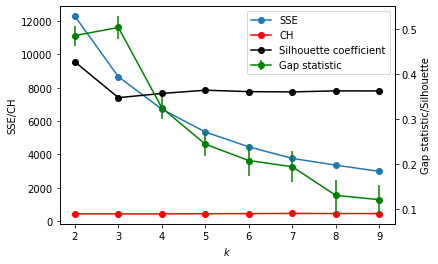

In [22]:
plot_internal(kmeans_conf_gov['inertias'], kmeans_conf_gov['chs'],
              kmeans_conf_gov['scs'],  kmeans_conf_gov['gss'],
              kmeans_conf_gov['gssds']);

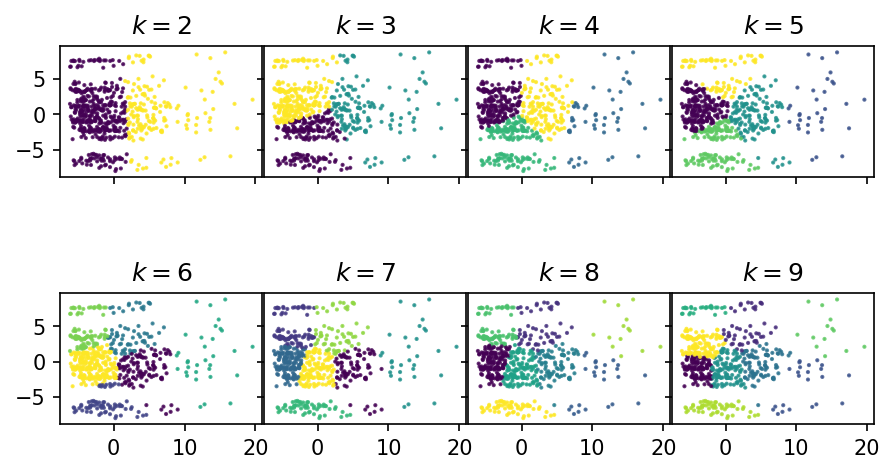

In [23]:
plot_clusters(x_pca_gov, kmeans_conf_gov['ys']);

#### COM

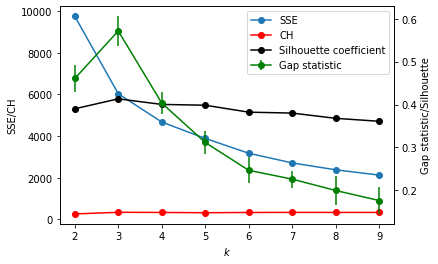

In [24]:
plot_internal(kmeans_conf_com['inertias'], kmeans_conf_com['chs'],
              kmeans_conf_com['scs'],  kmeans_conf_com['gss'],
              kmeans_conf_com['gssds']);

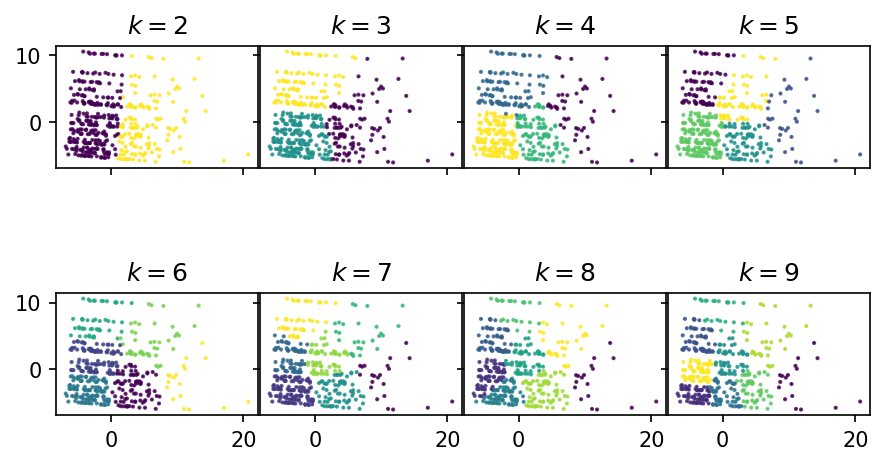

In [25]:
plot_clusters(x_pca_com, kmeans_conf_com['ys']);

#### PH

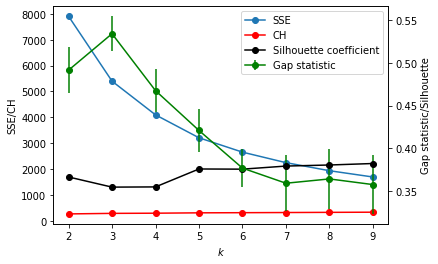

In [26]:
plot_internal(kmeans_conf_ph['inertias'], kmeans_conf_ph['chs'],
              kmeans_conf_ph['scs'],  kmeans_conf_ph['gss'],
              kmeans_conf_ph['gssds']);

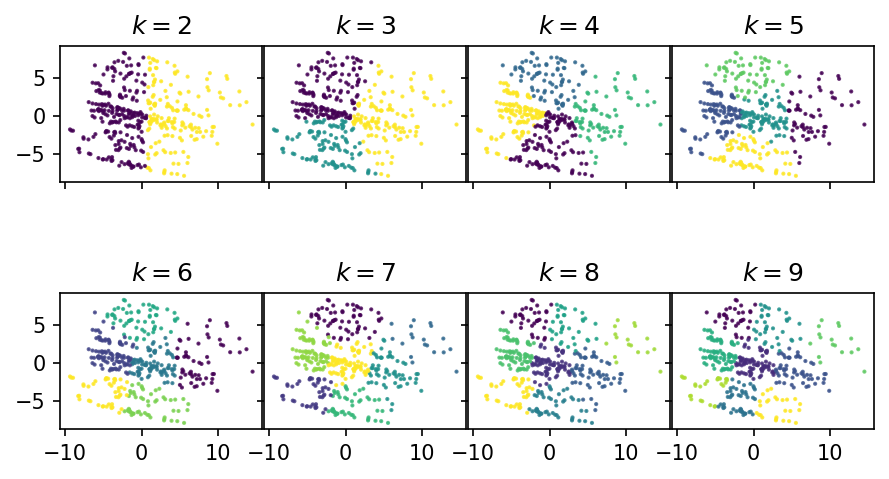

In [27]:
plot_clusters(x_pca_ph, kmeans_conf_ph['ys']);

### conference stats KMedians

In [42]:
kmedians_conf_gov = cluster_range_kmedians(x_pca_gov, 2, 9)
kmedians_conf_com = cluster_range_kmedians(x_pca_com, 2, 9)
kmedians_conf_ph = cluster_range_kmedians(x_pca_ph, 2, 9)

#### GOV

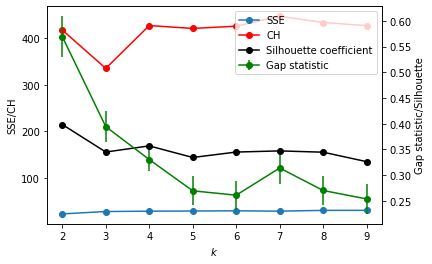

In [43]:
plot_internal(kmedians_conf_gov['inertias'], kmedians_conf_gov['chs'],
              kmedians_conf_gov['scs'],  kmedians_conf_gov['gss'],
              kmedians_conf_gov['gssds']);

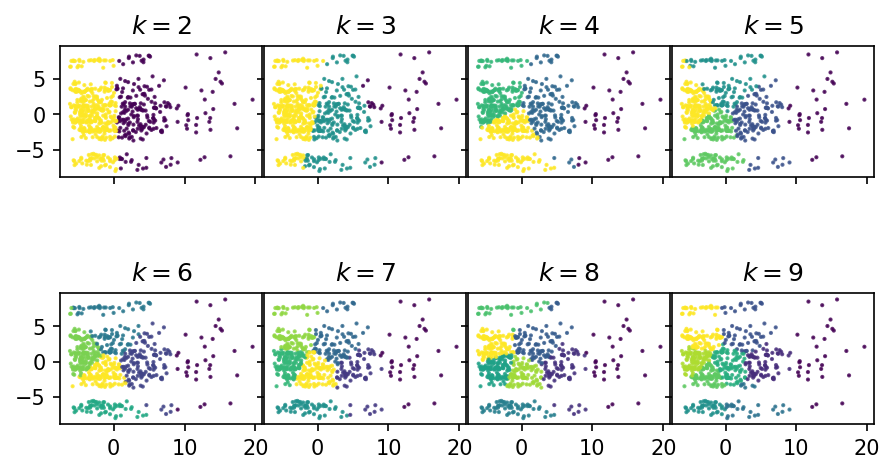

In [44]:
plot_clusters(x_pca_gov, kmedians_conf_gov['ys']);

#### COM

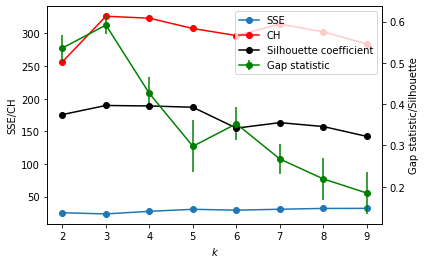

In [45]:
plot_internal(kmedians_conf_com['inertias'], kmedians_conf_com['chs'],
              kmedians_conf_com['scs'],  kmedians_conf_com['gss'],
              kmedians_conf_com['gssds']);

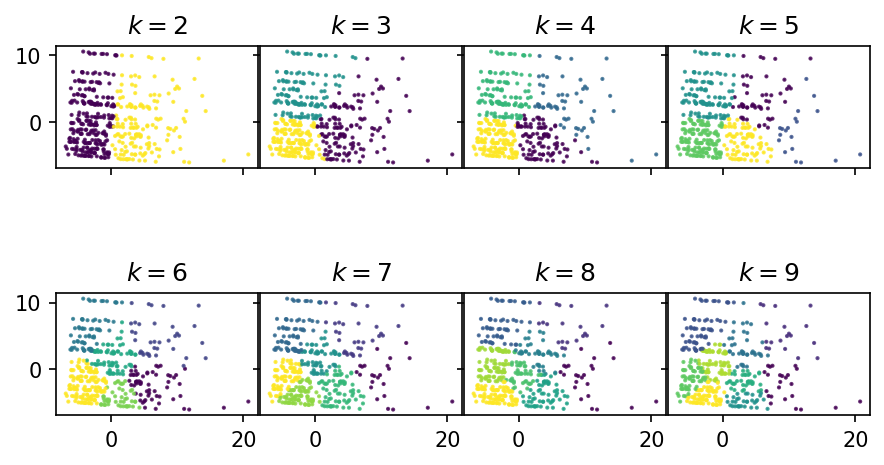

In [46]:
plot_clusters(x_pca_com, kmedians_conf_com['ys']);

#### PH

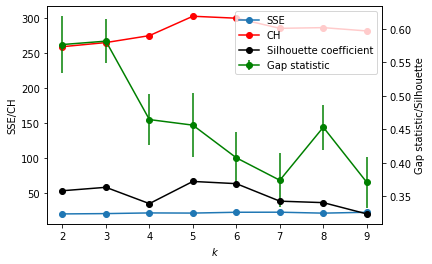

In [47]:
plot_internal(kmedians_conf_ph['inertias'], kmedians_conf_ph['chs'],
              kmedians_conf_ph['scs'],  kmedians_conf_ph['gss'],
              kmedians_conf_ph['gssds']);

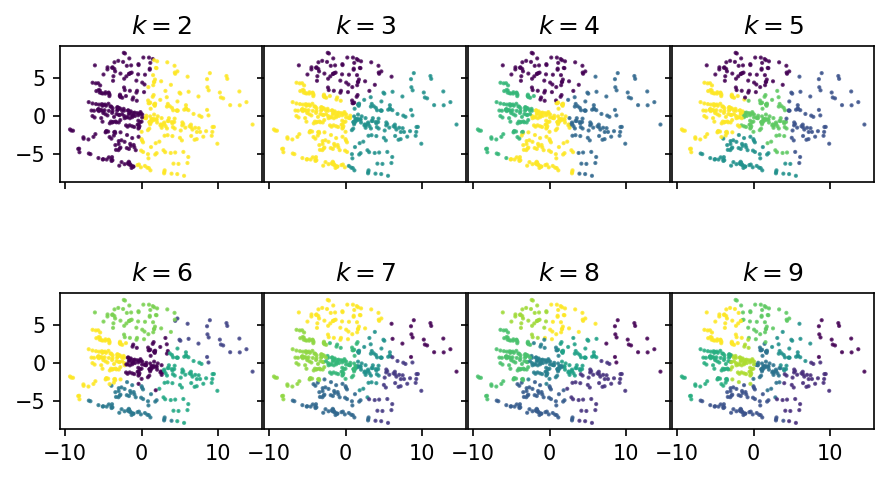

In [48]:
plot_clusters(x_pca_ph, kmedians_conf_ph['ys']);

### conference stats KMedoids

In [63]:
kmedoids_conf_gov = cluster_range_kmedoids(x_pca_gov, 2, 9)
kmedoids_conf_com = cluster_range_kmedoids(x_pca_com, 2, 9)
kmedoids_conf_ph = cluster_range_kmedoids(x_pca_ph, 2, 9)

#### GOV

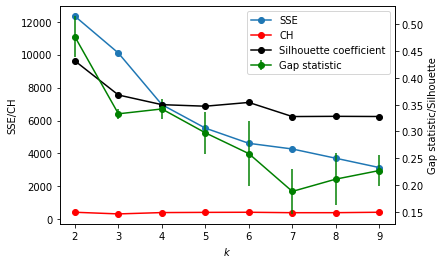

In [64]:
plot_internal(kmedoids_conf_gov['inertias'], kmedoids_conf_gov['chs'],
              kmedoids_conf_gov['scs'],  kmedoids_conf_gov['gss'],
              kmedoids_conf_gov['gssds']);

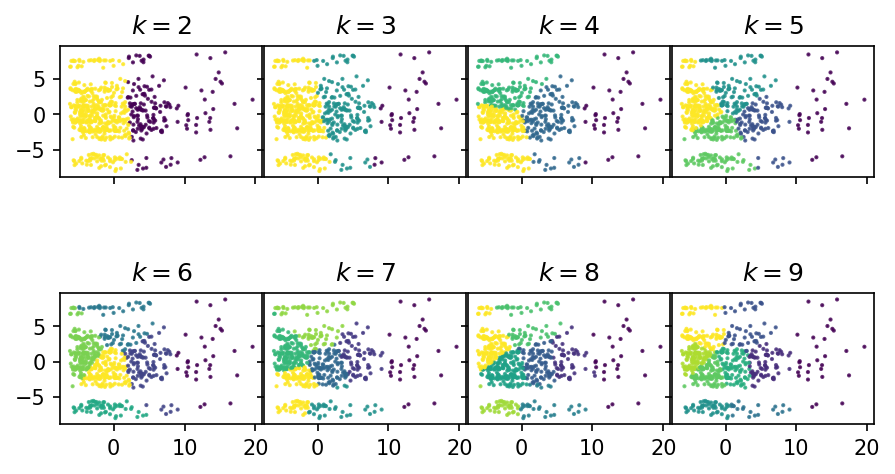

In [65]:
plot_clusters(x_pca_gov, kmedoids_conf_gov['ys']);

#### COM

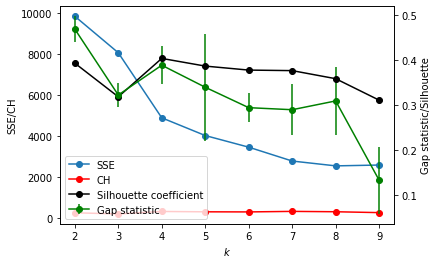

In [66]:
plot_internal(kmedoids_conf_com['inertias'], kmedoids_conf_com['chs'],
              kmedoids_conf_com['scs'],  kmedoids_conf_com['gss'],
              kmedoids_conf_com['gssds']);

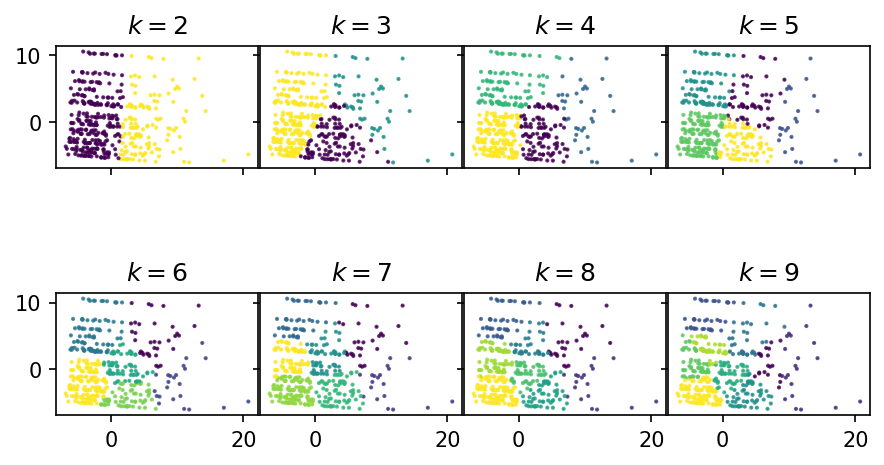

In [67]:
plot_clusters(x_pca_com, kmedoids_conf_com['ys']);

#### PH

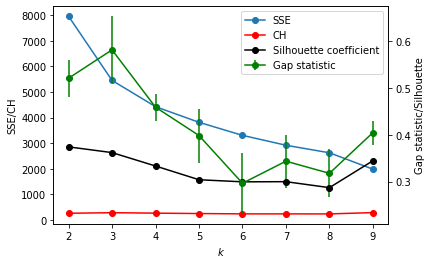

In [68]:
plot_internal(kmedoids_conf_ph['inertias'], kmedoids_conf_ph['chs'],
              kmedoids_conf_ph['scs'],  kmedoids_conf_ph['gss'],
              kmedoids_conf_ph['gssds']);

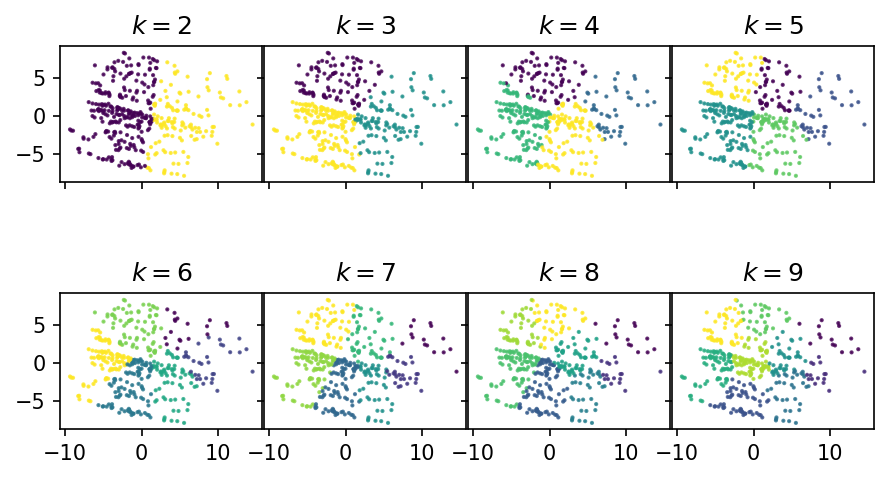

In [69]:
plot_clusters(x_pca_ph, kmedoids_conf_ph['ys']);

## Player Stats Clustering

### player stats KMeans

In [28]:
kmeans_gov_ply = cluster_range(x_pca_gov_ply, KMeans(random_state=0), 2, 9)
kmeans_com_ply = cluster_range(x_pca_com_ply, KMeans(random_state=0), 2, 9)
kmeans_ph_ply = cluster_range(x_pca_ph_ply, KMeans(random_state=0), 2, 9)

#### GOV

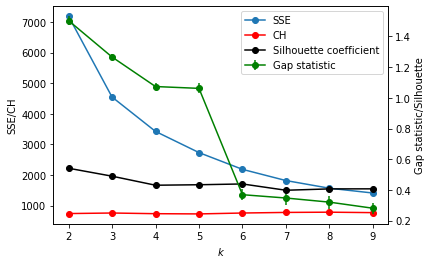

In [29]:
plot_internal(kmeans_gov_ply['inertias'], kmeans_gov_ply['chs'],
              kmeans_gov_ply['scs'],  kmeans_gov_ply['gss'],
              kmeans_gov_ply['gssds']);

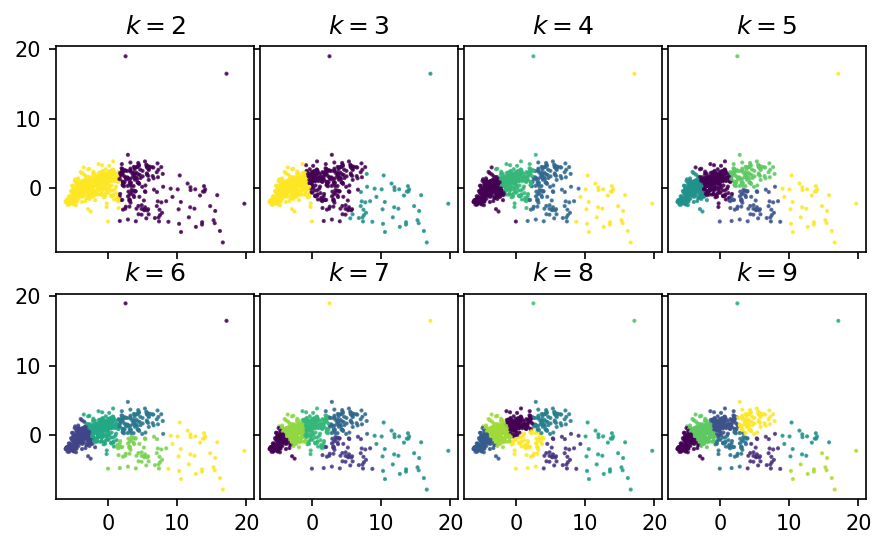

In [30]:
plot_clusters(x_pca_gov_ply, kmeans_gov_ply['ys']);

#### COM

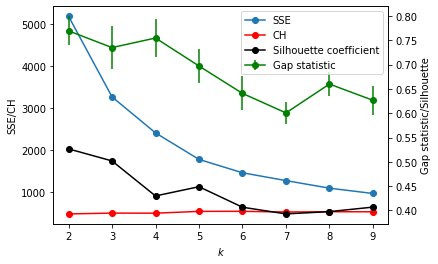

In [31]:
plot_internal(kmeans_com_ply['inertias'], kmeans_com_ply['chs'],
              kmeans_com_ply['scs'],  kmeans_com_ply['gss'],
              kmeans_com_ply['gssds']);

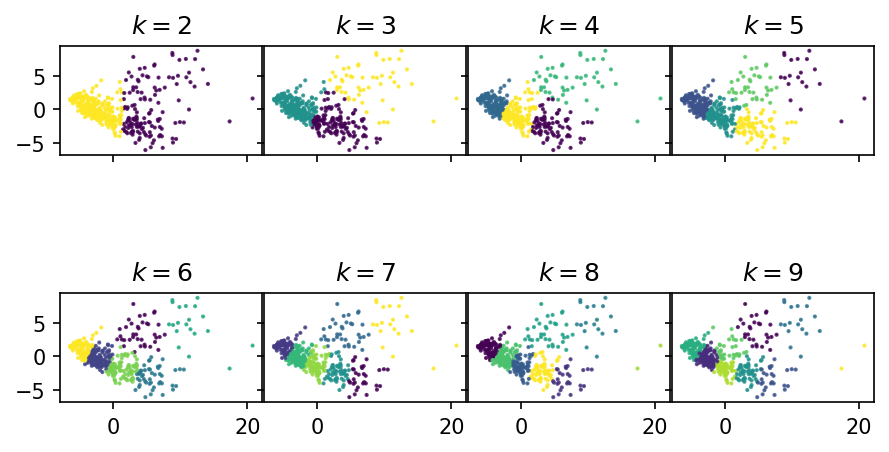

In [32]:
plot_clusters(x_pca_com_ply, kmeans_com_ply['ys']);

#### PH

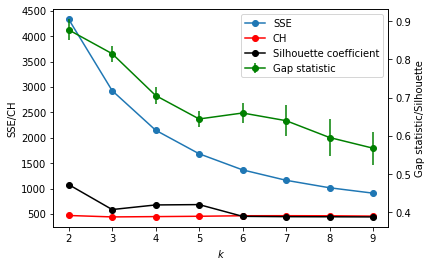

In [33]:
plot_internal(kmeans_ph_ply['inertias'], kmeans_ph_ply['chs'],
              kmeans_ph_ply['scs'],  kmeans_ph_ply['gss'],
              kmeans_ph_ply['gssds']);

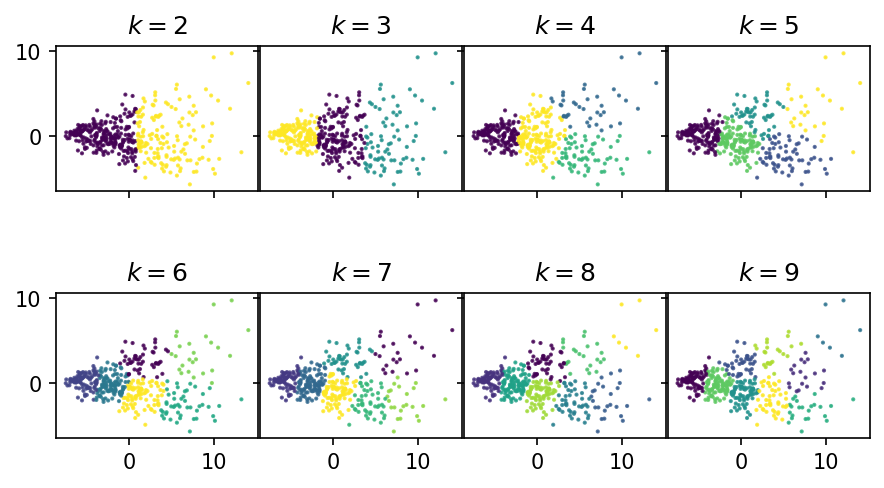

In [34]:
plot_clusters(x_pca_ph_ply, kmeans_ph_ply['ys']);

### player stats KMedians

In [49]:
kmedians_gov_ply = cluster_range_kmedians(x_pca_gov_ply, 2, 9)
kmedians_com_ply = cluster_range_kmedians(x_pca_com_ply, 2, 9)
kmedians_ph_ply = cluster_range_kmedians(x_pca_ph_ply, 2, 9)

#### GOV

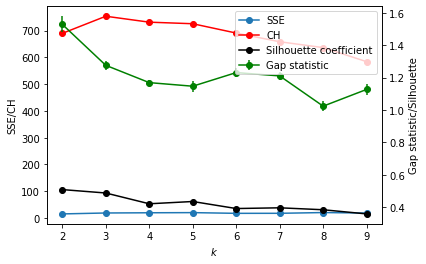

In [50]:
plot_internal(kmedians_gov_ply['inertias'], kmedians_gov_ply['chs'],
              kmedians_gov_ply['scs'],  kmedians_gov_ply['gss'],
              kmedians_gov_ply['gssds']);

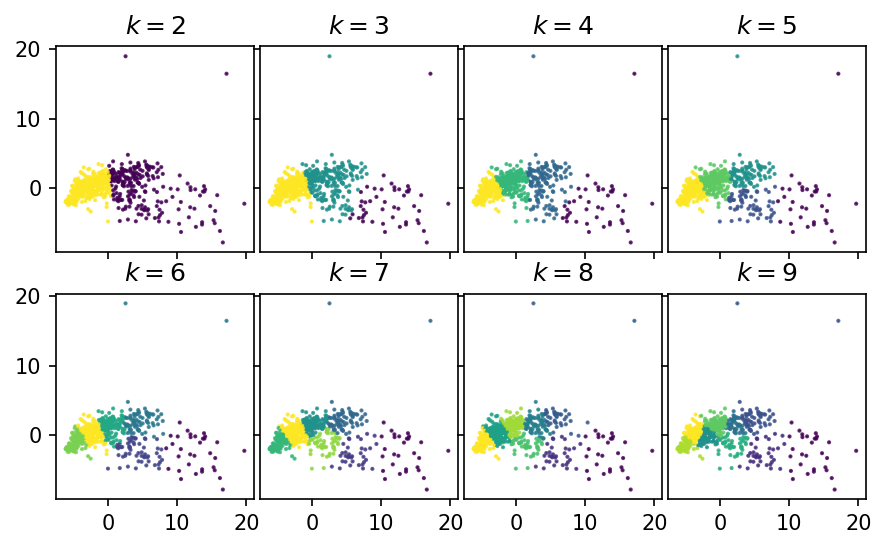

In [51]:
plot_clusters(x_pca_gov_ply, kmedians_gov_ply['ys']);

#### COM

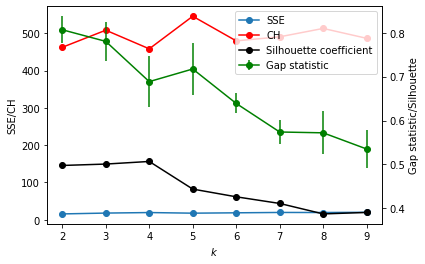

In [52]:
plot_internal(kmedians_com_ply['inertias'], kmedians_com_ply['chs'],
              kmedians_com_ply['scs'],  kmedians_com_ply['gss'],
              kmedians_com_ply['gssds']);

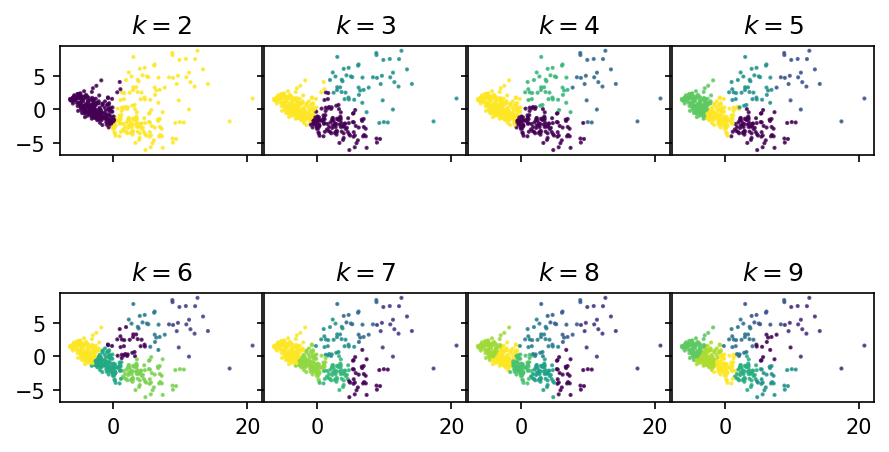

In [53]:
plot_clusters(x_pca_com_ply, kmedians_com_ply['ys']);

#### PH

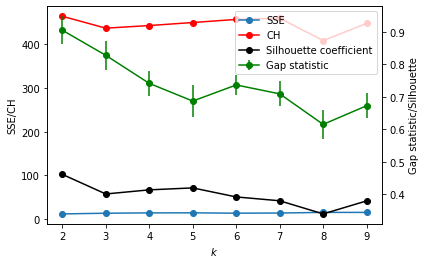

In [54]:
plot_internal(kmedians_ph_ply['inertias'], kmedians_ph_ply['chs'],
              kmedians_ph_ply['scs'],  kmedians_ph_ply['gss'],
              kmedians_ph_ply['gssds']);

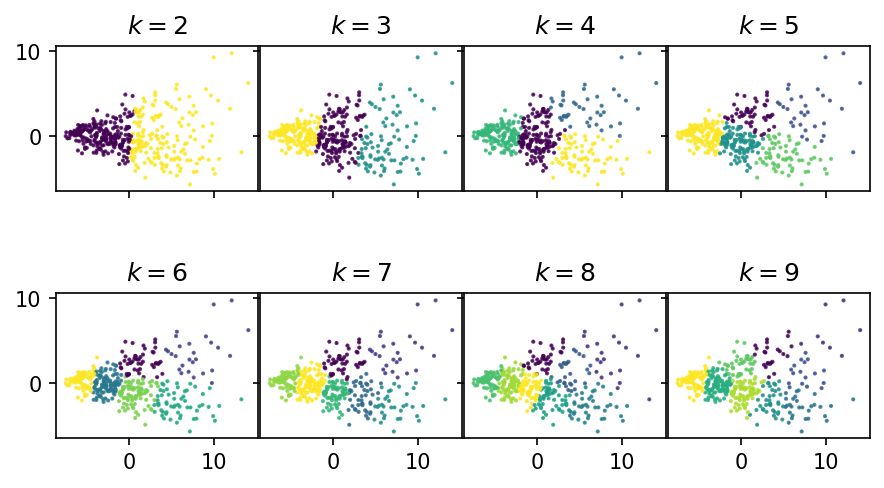

In [55]:
plot_clusters(x_pca_ph_ply, kmedians_ph_ply['ys']);

### player stats KMedoids

In [70]:
kmedoids_gov_ply = cluster_range_kmedoids(x_pca_gov_ply, 2, 9)
kmedoids_com_ply = cluster_range_kmedoids(x_pca_com_ply, 2, 9)
kmedoids_ph_ply = cluster_range_kmedoids(x_pca_ph_ply, 2, 9)

#### GOV

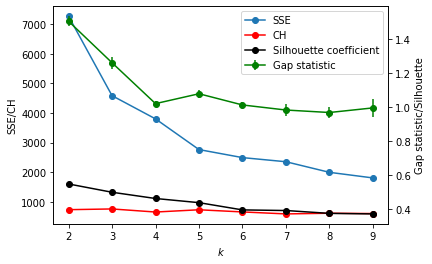

In [71]:
plot_internal(kmedoids_gov_ply['inertias'], kmedoids_gov_ply['chs'],
              kmedoids_gov_ply['scs'],  kmedoids_gov_ply['gss'],
              kmedoids_gov_ply['gssds']);

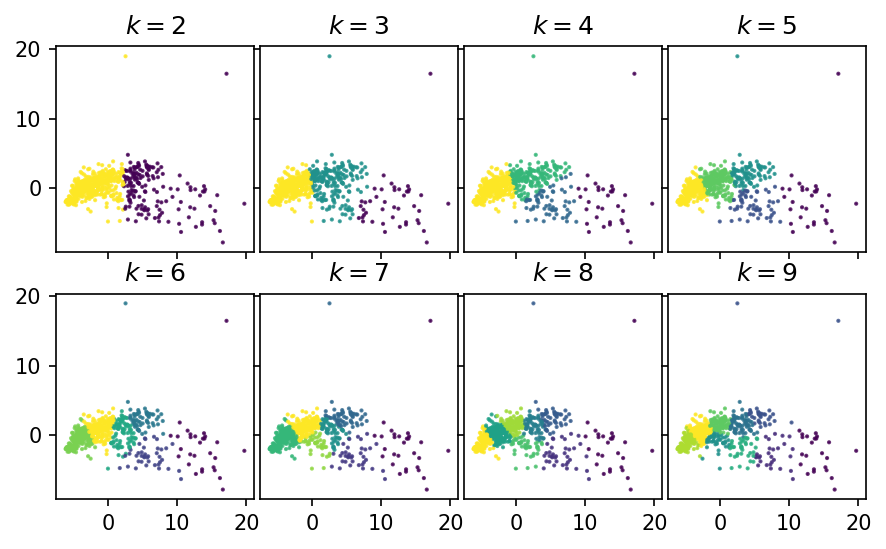

In [72]:
plot_clusters(x_pca_gov_ply, kmedoids_gov_ply['ys']);

#### COM

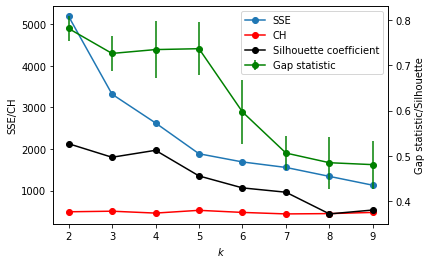

In [73]:
plot_internal(kmedoids_com_ply['inertias'], kmedoids_com_ply['chs'],
              kmedoids_com_ply['scs'],  kmedoids_com_ply['gss'],
              kmedoids_com_ply['gssds']);

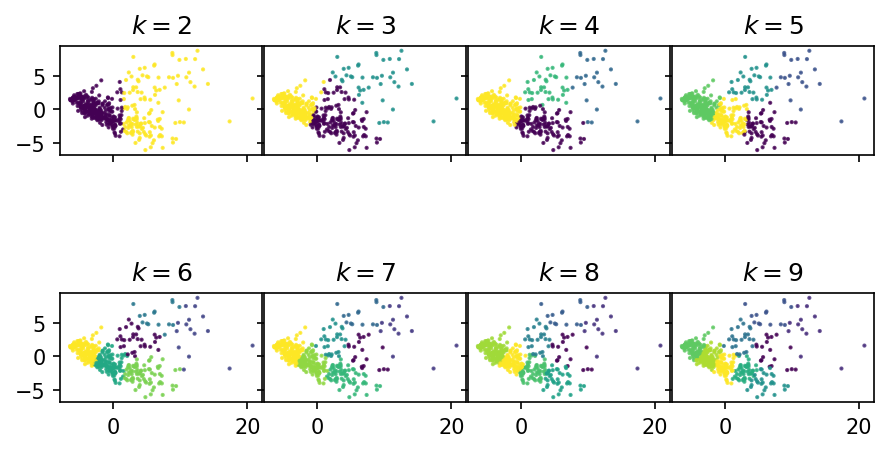

In [74]:
plot_clusters(x_pca_com_ply, kmedoids_com_ply['ys']);

#### PH

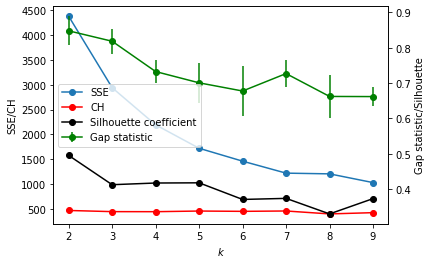

In [75]:
plot_internal(kmedoids_ph_ply['inertias'], kmedoids_ph_ply['chs'],
              kmedoids_ph_ply['scs'],  kmedoids_ph_ply['gss'],
              kmedoids_ph_ply['gssds']);

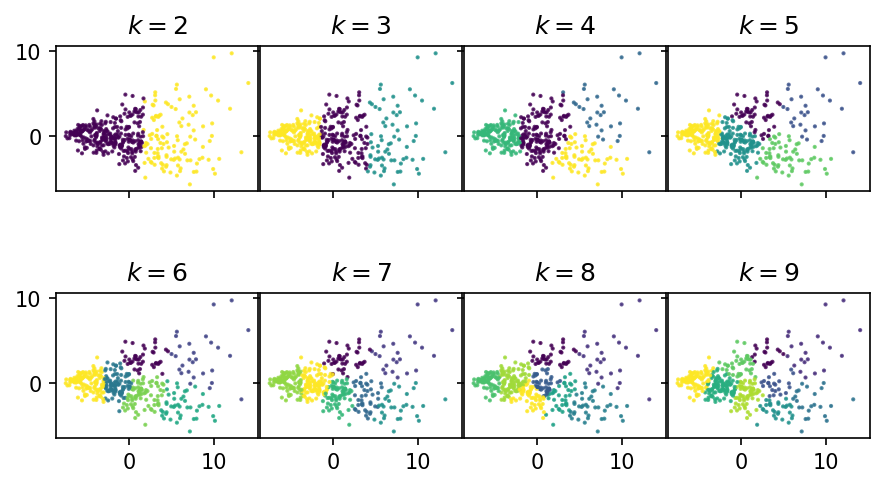

In [76]:
plot_clusters(x_pca_ph_ply, kmedoids_ph_ply['ys']);

## Team Stats Clustering

### team stats KMeans

In [35]:
kmeans_gov_tm = cluster_range(x_pca_gov_tm, KMeans(random_state=0), 2, 9)
kmeans_com_tm = cluster_range(x_pca_com_tm, KMeans(random_state=0), 2, 9)
kmeans_ph_tm = cluster_range(x_pca_ph_tm, KMeans(random_state=0), 2, 9)

#### GOV

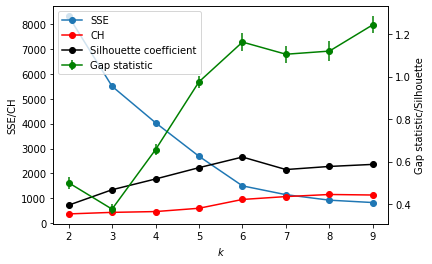

In [36]:
plot_internal(kmeans_gov_tm['inertias'], kmeans_gov_tm['chs'],
              kmeans_gov_tm['scs'],  kmeans_gov_tm['gss'],
              kmeans_gov_tm['gssds']);

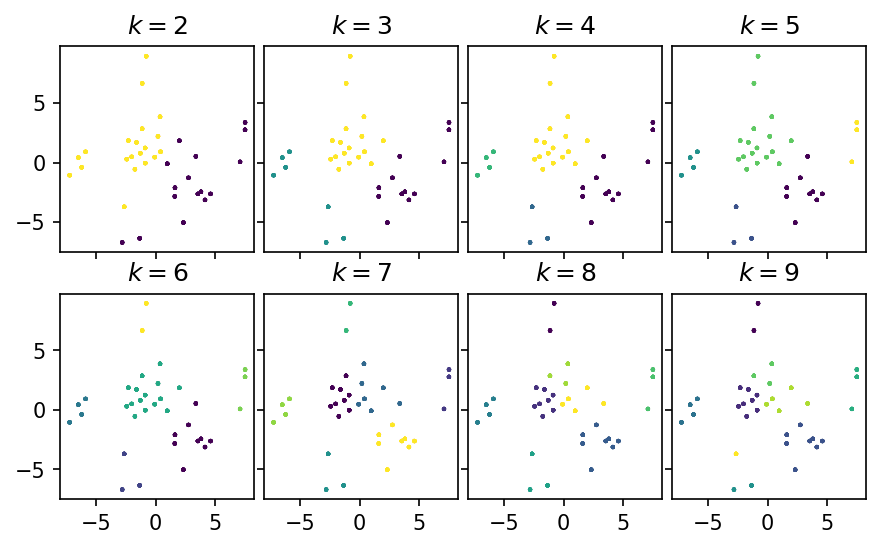

In [37]:
plot_clusters(x_pca_gov_tm, kmeans_gov_tm['ys']);

#### COM

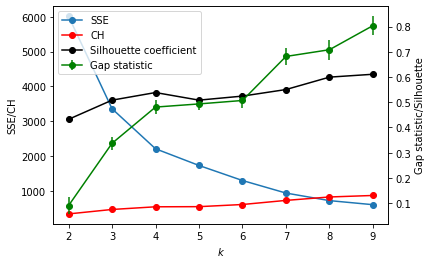

In [38]:
plot_internal(kmeans_com_tm['inertias'], kmeans_com_tm['chs'],
              kmeans_com_tm['scs'],  kmeans_com_tm['gss'],
              kmeans_com_tm['gssds']);

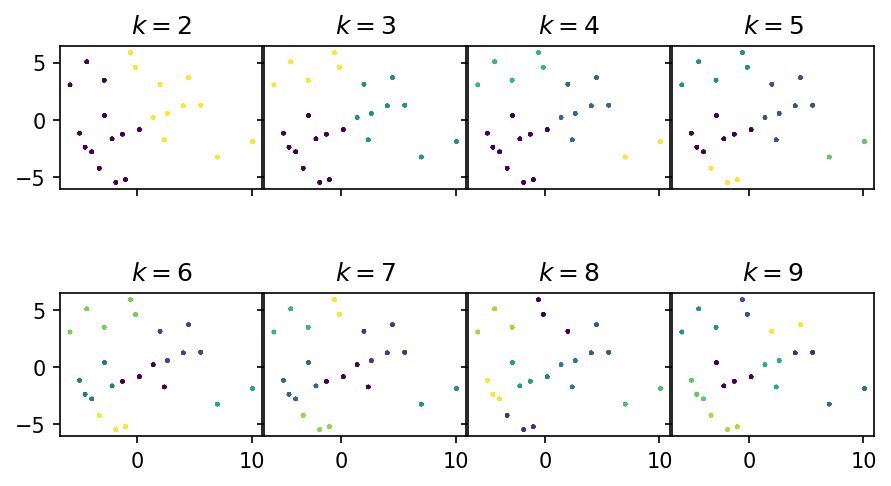

In [39]:
plot_clusters(x_pca_com_tm, kmeans_com_tm['ys']);

#### PH

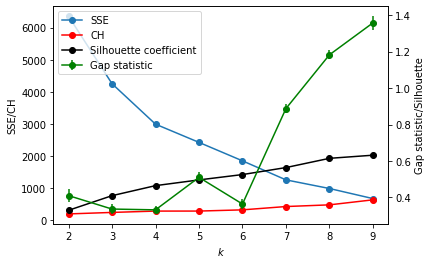

In [40]:
plot_internal(kmeans_ph_tm['inertias'], kmeans_ph_tm['chs'],
              kmeans_ph_tm['scs'],  kmeans_ph_tm['gss'],
              kmeans_ph_tm['gssds']);

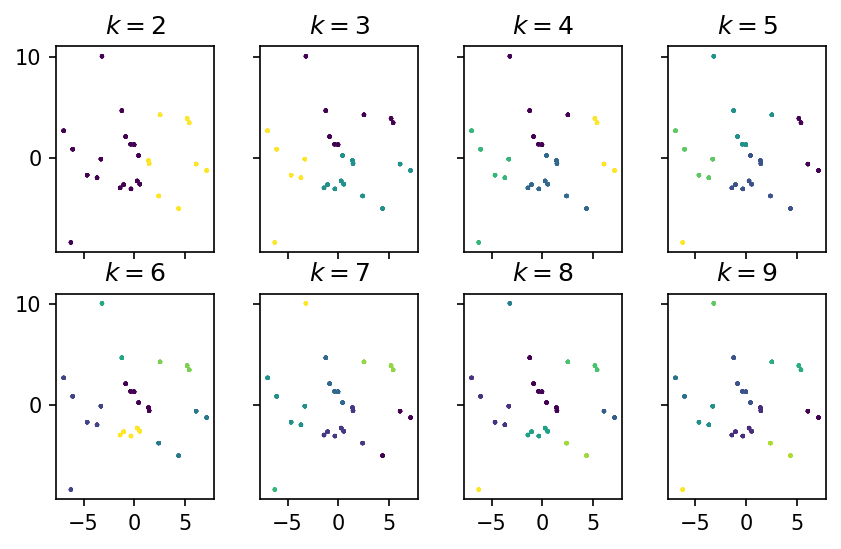

In [41]:
plot_clusters(x_pca_ph_tm, kmeans_ph_tm['ys']);

### team stats KMedians

In [56]:
kmedians_gov_tm = cluster_range_kmedians(x_pca_gov_tm, 2, 9)
kmedians_com_tm = cluster_range_kmedians(x_pca_com_tm, 2, 9)
kmedians_ph_tm = cluster_range_kmedians(x_pca_ph_tm, 2, 9)

#### GOV

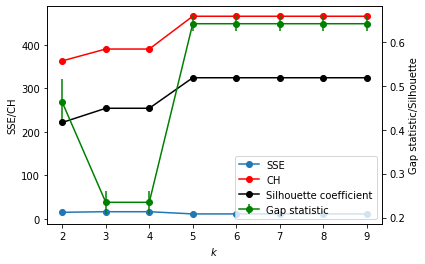

In [57]:
plot_internal(kmedians_gov_tm['inertias'], kmedians_gov_tm['chs'],
              kmedians_gov_tm['scs'],  kmedians_gov_tm['gss'],
              kmedians_gov_tm['gssds']);

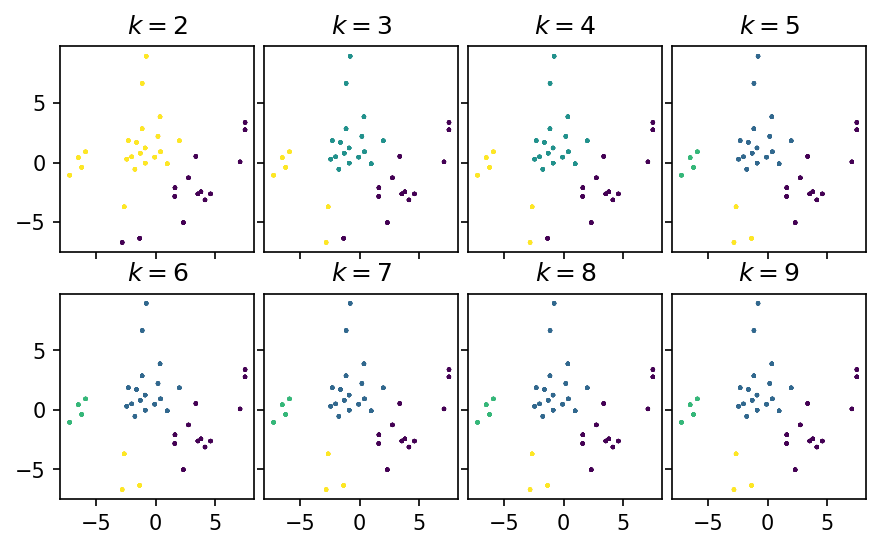

In [58]:
plot_clusters(x_pca_gov_tm, kmedians_gov_tm['ys']);

#### COM

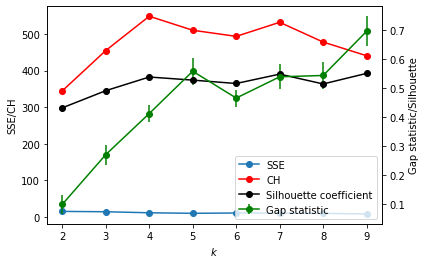

In [59]:
plot_internal(kmedians_com_tm['inertias'], kmedians_com_tm['chs'],
              kmedians_com_tm['scs'],  kmedians_com_tm['gss'],
              kmedians_com_tm['gssds']);

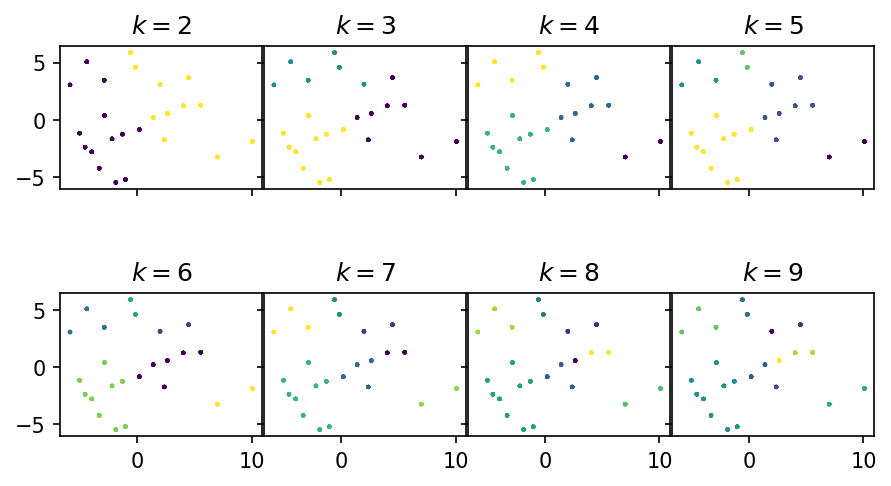

In [60]:
plot_clusters(x_pca_com_tm, kmedians_com_tm['ys']);

#### PH

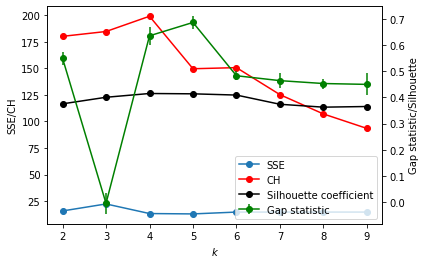

In [61]:
plot_internal(kmedians_ph_tm['inertias'], kmedians_ph_tm['chs'],
              kmedians_ph_tm['scs'],  kmedians_ph_tm['gss'],
              kmedians_ph_tm['gssds']);

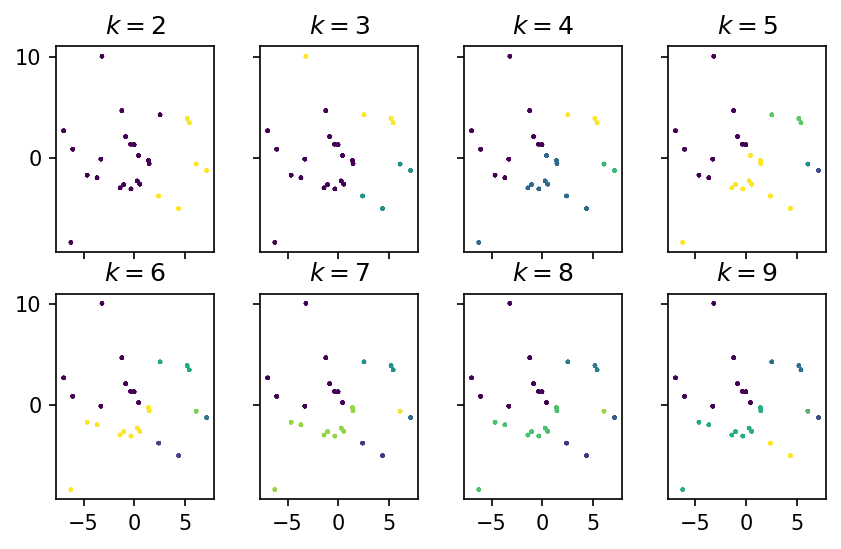

In [62]:
plot_clusters(x_pca_ph_tm, kmedians_ph_tm['ys']);

### team stats KMedoids

In [77]:
kmedoids_gov_tm = cluster_range_kmedoids(x_pca_gov_tm, 2, 9)
kmedoids_com_tm = cluster_range_kmedoids(x_pca_com_tm, 2, 9)
kmedoids_ph_tm = cluster_range_kmedoids(x_pca_ph_tm, 2, 9)

#### GOV

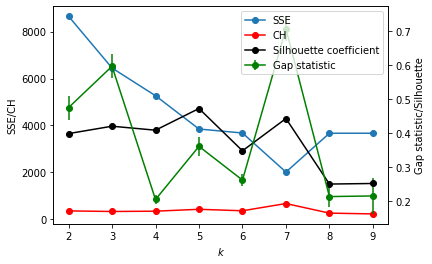

In [78]:
plot_internal(kmedoids_gov_tm['inertias'], kmedoids_gov_tm['chs'],
              kmedoids_gov_tm['scs'],  kmedoids_gov_tm['gss'],
              kmedoids_gov_tm['gssds']);

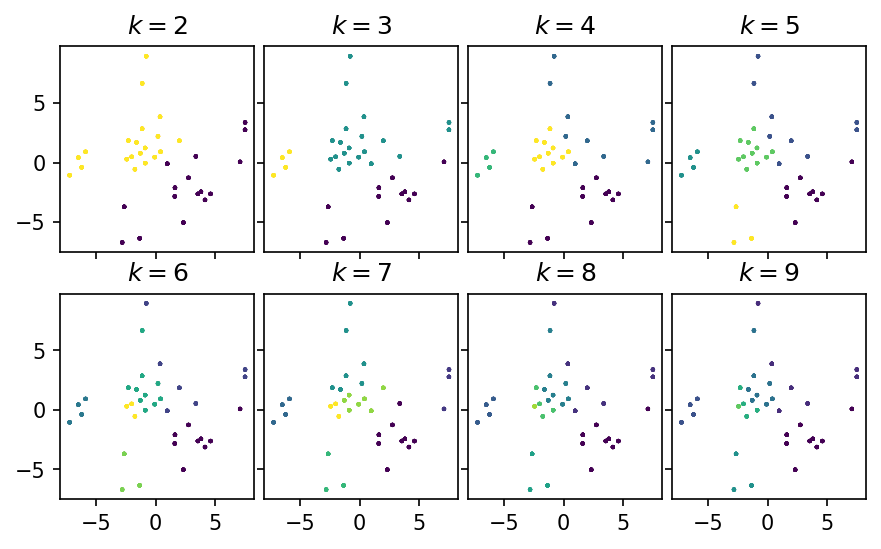

In [79]:
plot_clusters(x_pca_gov_tm, kmedoids_gov_tm['ys']);

#### COM

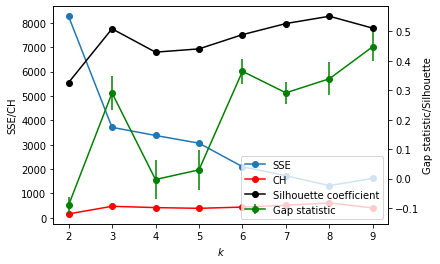

In [80]:
plot_internal(kmedoids_com_tm['inertias'], kmedoids_com_tm['chs'],
              kmedoids_com_tm['scs'],  kmedoids_com_tm['gss'],
              kmedoids_com_tm['gssds']);

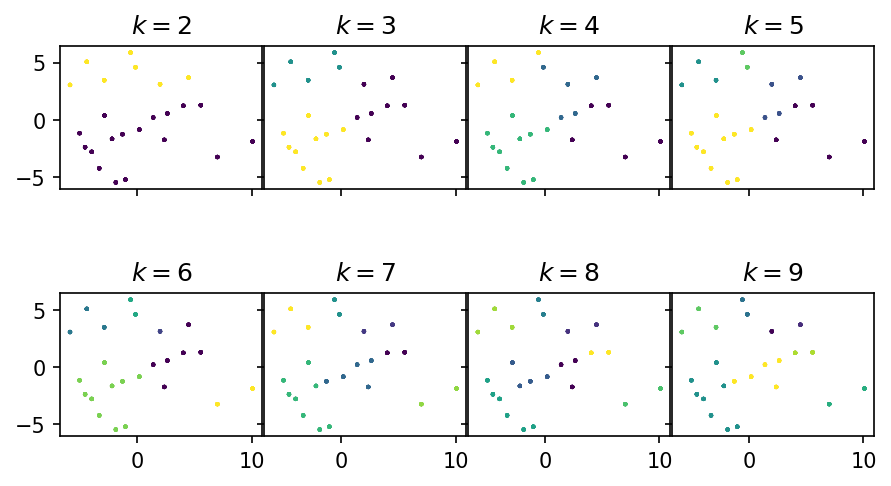

In [81]:
plot_clusters(x_pca_com_tm, kmedoids_com_tm['ys']);

#### PH

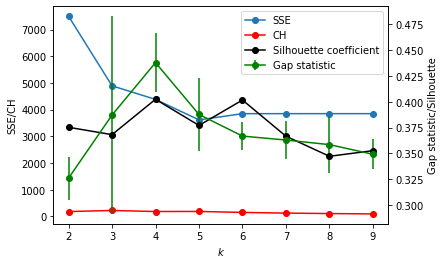

In [82]:
plot_internal(kmedoids_ph_tm['inertias'], kmedoids_ph_tm['chs'],
              kmedoids_ph_tm['scs'],  kmedoids_ph_tm['gss'],
              kmedoids_ph_tm['gssds']);

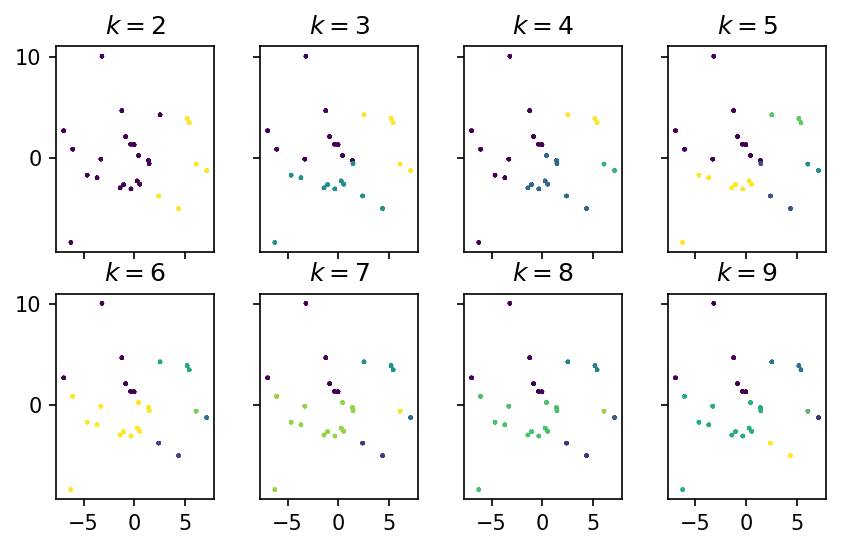

In [83]:
plot_clusters(x_pca_ph_tm, kmedoids_ph_tm['ys']);